# <center> IESO ML Project </center>

<center> notebook three <br> Feature Engineering <br> and <br> Principal Component Analysis</center>

Prepared by Behrouz ShakeriFard <br>

email: bshakeri@torontomu.ca <br>
April 2024

<hr>

In the previous notebook, we did some exploratory data analysis. We learned a few things:
1. Demand for electricity tends to be higher as weather temperatures deviate from 'comfortable'. That is to say, during winter and summer, we are more likely to see higher levels of demand.
2. Demand fluctuates during different hours of the day.
3. Peak demand tends to happen around different times of day, depending on the season (around 12PM to 3PM for summer time, and around 6PM during the cold season)
4. Prices tend to stay around $0 to $35 for the most part; however, price spikes can easily reach $300 for each MWh of energy.
5. Ontario's output chases demand; so, fluctuations follow the same patterns that we saw for demand.


Next, we should exploit what we know and construct variables that would help us predict sharp price spikes.

<hr>

# Correlation Matrix

Prior to doing any statistical analysis, we should get an idea how are these variables' fluctuations correlated.

Let's import a few useful packages, and get started!

In [1]:
import numpy as np 
import pandas as pd


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from pylab import *
from matplotlib import style


In [9]:
# Let's import our data
df = pd.read_csv('df_ieso_cleaned_2021.csv')

In [10]:
# sanity check
df.head()

,Unnamed: 0,Date Time,Market Demand,Ontario Demand,HOEP,Output,capability
0,0,2021-01-01 01:00:00,16057,14112,31.74,14301.0,26203.0
1,1,2021-01-01 02:00:00,15516,13504,17.61,13786.0,26494.0
2,2,2021-01-01 03:00:00,15185,13155,14.36,13507.0,26587.0
3,3,2021-01-01 04:00:00,14940,12892,10.26,13505.0,26749.0
4,4,2021-01-01 05:00:00,14802,12798,6.03,12881.0,26843.0


In [11]:
# Some clean-up is due
df.drop('Unnamed: 0', inplace=True, axis=1)
df.index = pd.to_datetime(df['Date Time'])
df.drop('Date Time', inplace=True, axis=1)

In [12]:
df.head()

,Market Demand,Ontario Demand,HOEP,Output,capability
Date Time,,,,,
2021-01-01 01:00:00,16057,14112,31.74,14301.0,26203.0
2021-01-01 02:00:00,15516,13504,17.61,13786.0,26494.0
2021-01-01 03:00:00,15185,13155,14.36,13507.0,26587.0
2021-01-01 04:00:00,14940,12892,10.26,13505.0,26749.0
2021-01-01 05:00:00,14802,12798,6.03,12881.0,26843.0


All is well.

Let's look at our Correlation Matrix now.

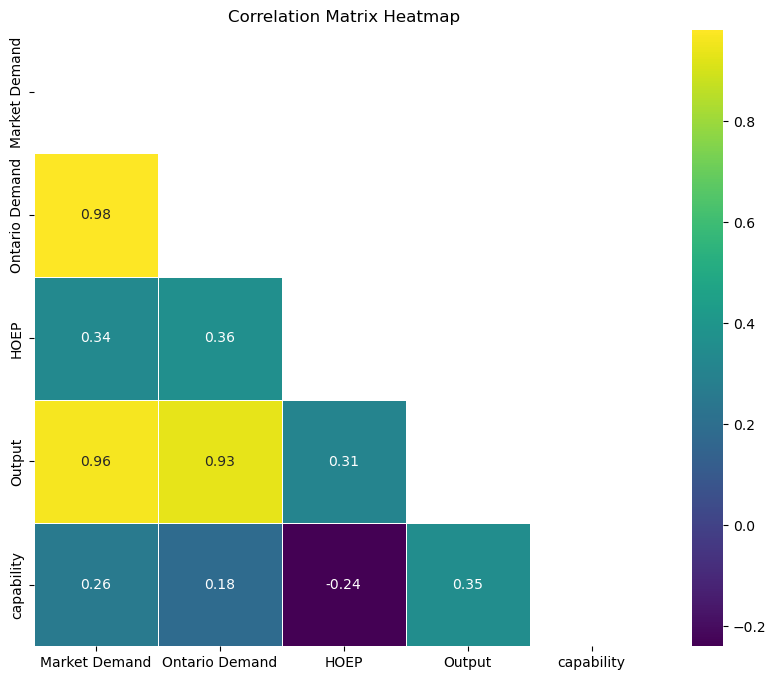

In [13]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.7, mask=mask)

# Show the plot
plt.title('Correlation Matrix Heatmap')
plt.show()

Cool.

Let's investigate possible avenues to extract insight from this matrix.

1. Ontario Demand and Market Demand have the strongest correlation, standing at 0.98
2. Market Demand and Output have the second strongest correlation, standing at 0.96. This is not surprising. As demand fluctuates, system's operator reacts in order to balance the electricity generation with electricity demand.
3. Same is true for Ontario Demand and Output, standing at 0.93
4. HOEP (Hourly Ontario's Electricity Price) has the strongest correlation with with Ontario Demand, standing at 0.36. The interpretation is fairly simple: as Ontario's Demand rises, system's operator (IESO) raises the price in order to entice electricity producers to engage their capacity and offer their electricity to the grid.
5. HOEP's correlation with output, standing at 0.31 is next in line. Output is one step removed from demand; thus the correlation should be observed with caution against deducing any form of causation. The cause and effect relation ship (if true) goes from raising price to rising output; not the other way around.
6. Last but not least, HOEP and Capability. This is the only relationship which exhibits negative value. And it makes sense! As capacity to produce increases, we would be seeing more producers pushing the demand and supply curve down, towards an equilibrium that can deliver each unit of electricity at a lower cost.

<hr>



# <center> Feature Engineering </center>

George Soros famously observed that market's fluctuations are caused by foreces that push variables towards an imaginary equilibrium; thus, they remain in perpetual disequilibrium. This insight is going to be very useful. 

Consider Ontario's Demand and Market Demand. Ontario's Demand has the stronger correlation with price; however, its correlation with output stands at 0.93; suggesting a gap, that could be caused by a lag in system. We are going to exploit this gap (disequilibrium) and see whether we can construct a new feature or not; and of so, see how that feature could be exploited to predict price spikes.

## 1. Market Surplus/Deficit

In [26]:
df['Market Surplus'] = df['Output'] - df['Ontario Demand']

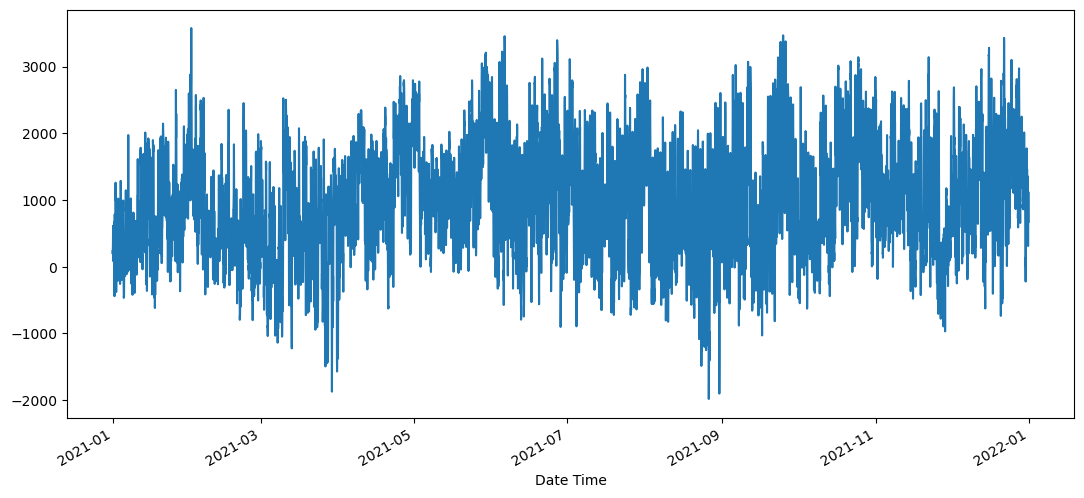

In [27]:
# initializing the plot figure
plt.figure(figsize=(13,6))

# passing the dataframe to the plot function
df['Market Surplus'].plot()

# show the plot
plt.show()

Ontario's market seem to be in surplus for the most part. This is good news; because as it goes into deficit, we should be able to predict <i>increased</i> probability of price spikes. This is a hypothesis, which we will test.




Next, we are going to use 'Standard Scalar' component of <i> sklearn </i> package and do a quick <i> Pearson test </i>.

In [23]:
# We need this package for standardization
from sklearn.preprocessing import StandardScaler

# We need this package for our pearson test of statistical significance
from scipy.stats import pearsonr

In [28]:
# We are going conduct the Pearson test, using a new dataframe

# create a new dataframe, to be filled with data, and then standardized
df_standardized = pd.DataFrame()

# Create a new DataFrame with the columns you want to standardize
df_standardized['Price'] = df['HOEP']
df_standardized['Market Surplus'] = df['Market Surplus']

# Standardize the columns using StandardScaler
scaler = StandardScaler()
df_standardized[['Price', 'Market Surplus']] = scaler.fit_transform(df_standardized[['Price', 'Market Surplus']])

# Calculate the correlation coefficient
correlation = df_standardized['Price'].corr(df_standardized['Market Surplus'])

# Print the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: -0.2763910411574461


Very cool. But how do we know whether this correlation is statistically significant or not? 

We need to do a Pearson test!

In [30]:
# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df_standardized['Price'], df_standardized['Market Surplus'])

# Print the correlation coefficient and p-value
print("Correlation coefficient of Pearson test:", correlation_coefficient)
print("P-value of Pearson test:", p_value)

Correlation coefficient of Pearson test: -0.2763910411574463
P-value of Pearson test: 2.286467773233973e-153


As we can see, the P-value is extremely small; which means, the observed correlation is meaningful (n other words, statistically significant).

Let's move on to the next step.

## 2. Annual Deficit

Our next feature is constructed using some insights derived from the role of expectation.

In [32]:
# clean up
df.drop('Market Deficit',axis=1,inplace=True)

In [51]:
# sanity check 
df.sample(3,random_state=27)

,Market Demand,Ontario Demand,HOEP,Output,capability,Market Surplus
Date Time,,,,,,
2021-03-13 06:00:00,15455,14224,79.46,13632.0,26182.0,-592.0
2021-01-11 16:00:00,20110,17951,14.09,18464.0,29014.0,513.0
2021-12-10 10:00:00,19117,17815,35.83,18089.0,27413.0,274.0


We have come across something strange. Consider these two data points: 2021-03-13 06 (price recorded \\$79.46 for each MWh, while demand is 14,224 MWh) and 2021-01-11 (price recorded $14.09 for each MWh, while demand is 17,951 MWh). This is counter intuitive!

We should expect lower demand (14,224 MWh) come with lower price. But it doesn't!

This requires further investigation. Let's take another sample.

### Hypothesis:

Market demand (in theory) should influence price. But a quick look at the data we see here, suggests truth is abit more nuanced. Take data points 7593 and 28 for example. The index 2021-03-13 06:00:00 is a mid March day with 14,224 MWh of demand in the system, yet price is \\$79.46 - ufficiently high to be called spike! 

Data point index 2021-01-11, on the other hand, has registered a demand of 17,951 MWh (lower than 14,224) with a price of $14.09. What is going on?

The answer lies in a key-word that economists use a lot: expectations. 

The first data point (2021-03-13) has been recorded in early morning, on a winter day (at 6 a.m.) when demand is supposed to be stable. Yet, we see a marked deficit in the system: a value of -592 MWh. This time of day (6 a.m.) is when citizens are starting their daily activities. Meaning, any shock to the system - due to unpredictable behavior - can push the system into disequilibrium. In other words, it is safe to assume that there was a shock in demand. This requires further investigation.

The second data point (2021-01-11) on the other hand was recorded at 4 p.m. This is a winter day, prior to citizen's returning to home. It is safe to assume that demand must have been stable, as predicted. Best way of assessing these assumptions is looking at previous data to see how much deviation from the expectation (observed behaviour in the past) can influence price movements.

<hr>

This is why having a frame of reference becomes useful. It is worth asking *what level of demand should we expect around this time of day, around this time of year?* And it is worth exploring the theory that, perhaps, significant increase in demand in comparison to the same data point in previous years, would be a shock to the system, and will catch the operator off guard.

We need to look at previous year's data in order to find out.


In [64]:
# importing data from the previous year
d_2020 = pd.read_csv('PUB_Demand_2020_v396.csv')

In [65]:
# sanity check
d_2020.head(7)

,\\Hourly Demand Report,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,\\Created at 2021-01-31 07:30:13,NaN,NaN,NaN
1,\\For 2020,NaN,NaN,NaN
2,Date,Hour,Market Demand,Ontario Demand
3,2020-01-01,1,16565,13219
4,2020-01-01,2,16193,12895
5,2020-01-01,3,16072,12554
6,2020-01-01,4,15930,12360


In [66]:
# renaming columns
d_2020.columns=['Date', 'Hour','Market Demand','Ontario Demand']

# dropping rows that contain unuseful information
d_2020.drop([0,1,2], inplace = True)

# converting it to numeric data
d_2020['Ontario Demand'] = pd.to_numeric(d_2020['Ontario Demand'], errors='coerce')

In [67]:
d_2020.head(5)

,Date,Hour,Market Demand,Ontario Demand
3,2020-01-01,1,16565,13219
4,2020-01-01,2,16193,12895
5,2020-01-01,3,16072,12554
6,2020-01-01,4,15930,12360
7,2020-01-01,5,15963,12353


In [73]:
d_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 3 to 8786
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            8784 non-null   object
 1   Hour            8784 non-null   object
 2   Market Demand   8784 non-null   object
 3   Ontario Demand  8784 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 274.6+ KB


In [74]:
d_2020 = d_2020[d_2020['Date'] != '2020-02-29']

In [75]:
new_features_df = pd.DataFrame()

new_features_df['2020 Demand'] = d_2020['Ontario Demand'].values
new_features_df['2021 Demand'] = df['Ontario Demand'].values
new_features_df['Annual Surplus'] = new_features_df['2020 Demand'] - new_features_df['2021 Demand'] 

In [76]:
# sanity check
new_features_df.head(7)

,2020 Demand,2021 Demand,Annual Surplus
0,13219,14112,-893
1,12895,13504,-609
2,12554,13155,-601
3,12360,12892,-532
4,12353,12798,-445
5,12458,12891,-433
6,12729,13188,-459


In [77]:
new_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   2020 Demand     8760 non-null   int64
 1   2021 Demand     8760 non-null   int64
 2   Annual Surplus  8760 non-null   int64
dtypes: int64(3)
memory usage: 205.4 KB


Very cool.

Next we will standard scalar component, and do a quick Pearson test.

<hr>

## Pearson Test

In [88]:
# importing StandardScaler
scaler = StandardScaler()

# copy our new feature
df_standardized['Annual Surplus'] = new_features_df['Annual Surplus'].values

# Standardize our two columns
df_standardized[['Price', 'Annual Surplus']] = scaler.fit_transform(df_standardized[['Price', 'Annual Surplus']])

# Calculate the correlation coefficient
correlation = df_standardized['Price'].corr(df_standardized['Annual Surplus'])

# Print the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: -0.16756168631050597


In [89]:
# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df_standardized['Price'], df_standardized['Annual Surplus'])

# Print the correlation coefficient and p-value
print("Correlation coefficient of Pearson test:", correlation_coefficient)
print("P-value of Pearson test:", p_value)

Correlation coefficient of Pearson test: -0.1675616863105059
P-value of Pearson test: 3.5068973237520603e-56


This correlation coefficient is non-trivial. The error term (p-value) is also very small. However, it remains to be seen whether we will use this feature or not. Definitely not a waste of time!

<hr>

# 3. Output/Capacity Ratio

Right!

There is another feature that could give us some insight regarding how price of electricity fluctuates. And that is how much of the resources available are being used.

It would make sens for the system's operator to allow lower cost generators to come into the market first, and as demand begins to rise, ask for less efficient (and thus more expensive) generators to offer their electricity to the market. If true, this would mean as the system engages more and more of its capacity, the price must increase as well. Therefore, we should expect a positive correlation (perhaps in form of a forward indicator) between output/capacity ratio and prices.

So, let's construct this variable from the data that we have!
<hr>

In [90]:
df.columns

Index(['Market Demand', 'Ontario Demand', 'HOEP', 'Output', 'capability',
       'Market Surplus'],
      dtype='object')

In [91]:
# constructing a new Pandas Series
output_capacity_ratio = pd.Series(dtype=float)
output_capacity_ratio = df['Output']/df['capability']

In [92]:
# sanity check
output_capacity_ratio.shape

(8760,)

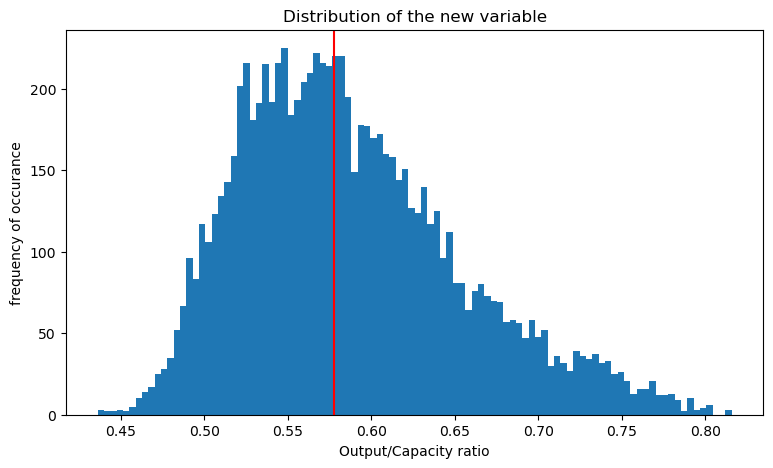

In [93]:
# Let's check out the distribution

# initializing the plot
plt.figure(figsize=(9,5))

# Histogram
output_capacity_ratio.plot(kind='hist',bins=100)

plt.axvline(output_capacity_ratio.median(), color='red')

plt.title('Distribution of the new variable')

plt.xlabel('Output/Capacity ratio')
plt.ylabel('frequency of occurance')
plt.show()

very cool!

Fore the most part, the system is using 52% to 58% of its resources.

In [96]:
new_features_df.columns

Index(['2020 Demand', '2021 Demand', 'Annual Surplus'], dtype='object')

In [100]:
output_capacity_ratio.dtype

dtype('float64')

In [101]:
type(output_capacity_ratio)

pandas.core.series.Series

In [106]:
new_features_df['Output/Cap'] = output_capacity_ratio.values

In [107]:
new_features_df.head()

,2020 Demand,2021 Demand,Annual Surplus,Output/Cap
0,13219,14112,-893,0.545777
1,12895,13504,-609,0.520344
2,12554,13155,-601,0.508030
3,12360,12892,-532,0.504879
4,12353,12798,-445,0.479864


In [108]:
new_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   2020 Demand     8760 non-null   int64  
 1   2021 Demand     8760 non-null   int64  
 2   Annual Surplus  8760 non-null   int64  
 3   Output/Cap      8760 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 273.9 KB


## HeatMap

In [146]:
output_cap_df = pd.DataFrame(index = df.index)

In [148]:
output_cap_df['output_capacity_ratio'] = output_capacity_ratio

In [149]:
# implementing the pivot
pivot_ocr = output_cap_df.pivot_table(index=df.index.date,columns=df.index.time,values="output_capacity_ratio")

In [151]:
# sanity check
pivot_ocr

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
2021-01-01,0.517411,0.545777,0.520344,0.508030,0.504879,0.479864,0.482624,0.491183,0.502121,0.511122,...,0.546141,0.564644,0.580965,0.570505,0.568250,0.574482,0.583087,0.571163,0.558037,0.543996
2021-01-02,0.520820,0.514379,0.502995,0.499481,0.515590,0.506770,0.508476,0.504244,0.508860,0.530197,...,0.574622,0.587889,0.594903,0.610841,0.646429,0.632731,0.613532,0.587710,0.566094,0.535439
2021-01-03,0.521297,0.492767,0.495291,0.492837,0.483667,0.491379,0.494488,0.498506,0.517008,0.543564,...,0.591444,0.598649,0.599567,0.626506,0.656846,0.653291,0.626827,0.613685,0.579294,0.545425
2021-01-04,0.560790,0.499675,0.501409,0.500542,0.510031,0.523361,0.535908,0.554004,0.578164,0.610716,...,0.650706,0.658689,0.665713,0.692028,0.694257,0.681950,0.647397,0.617676,0.597967,0.590297
2021-01-05,0.551256,0.517445,0.522497,0.521381,0.519835,0.529966,0.539290,0.554311,0.589940,0.614163,...,0.634380,0.638026,0.645193,0.668525,0.693733,0.683698,0.669200,0.652434,0.629821,0.575033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.556961,0.551939,0.524649,0.535301,0.521543,0.531790,0.550971,0.524985,0.537680,0.560856,...,0.624622,0.631820,0.621814,0.647556,0.664062,0.656037,0.661973,0.648742,0.638467,0.599153
2021-12-28,0.571961,0.539264,0.538229,0.541781,0.536131,0.530208,0.528402,0.549953,0.576740,0.591496,...,0.631348,0.636572,0.651470,0.666978,0.701756,0.676890,0.649870,0.656199,0.647076,0.602248
2021-12-29,0.548417,0.521581,0.517607,0.522616,0.527690,0.545761,0.544164,0.569864,0.583814,0.589045,...,0.617118,0.621022,0.642693,0.643638,0.676862,0.641979,0.635090,0.625219,0.599298,0.557274
2021-12-30,0.540355,0.523388,0.519539,0.523260,0.524013,0.532782,0.544203,0.567329,0.577543,0.594998,...,0.616459,0.609534,0.607921,0.615976,0.636833,0.616586,0.614323,0.593470,0.585072,0.557611


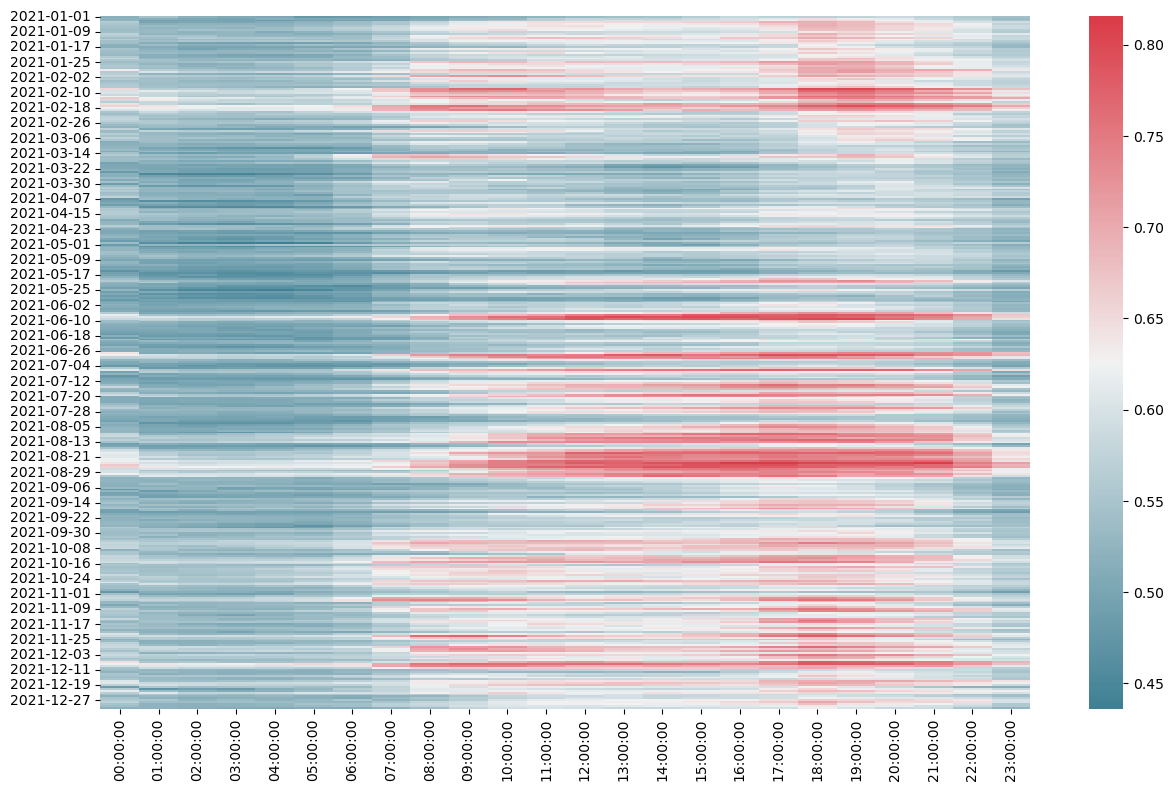

In [153]:
# setting the size of graph
plt.figure(figsize=(15,9))

# Define the custom color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# producing the graph
sns.heatmap(pivot_ocr,cmap=cmap)
plt.show()

## Pearson test

Cool. Let's do a quick Pearson test!

In [112]:
# Standardize the columns using StandardScaler
scaler = StandardScaler()

df_standardized['Output/Cap'] = new_features_df['Output/Cap'].values

df_standardized[['Price', 'Output/Cap']] = scaler.fit_transform(df_standardized[['Price', 'Output/Cap']])

# Calculate the correlation coefficient
correlation = df_standardized['Price'].corr(df_standardized['Output/Cap'])

# Print the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.4636210456936107


In [113]:
# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df_standardized['Price'], df_standardized['Output/Cap'])

# Print the correlation coefficient and p-value
print("Correlation coefficient of Pearson test:", correlation_coefficient)
print("P-value of Pearson test:", p_value)

Correlation coefficient of Pearson test: 0.4636210456936106
P-value of Pearson test: 0.0


very cool!

Here we see a strong correlation between the two variables of interest. Now let's take another look at the 'new_features_df' correlation matrix.

## Correlation Matrix

In [115]:
df_standardized.columns

Index(['Price', 'Market Surplus', 'Annual Surplus', 'Output/Cap ratio',
       'Output/Cap'],
      dtype='object')

In [116]:
df_standardized.drop('Output/Cap ratio',axis=1,inplace=True)

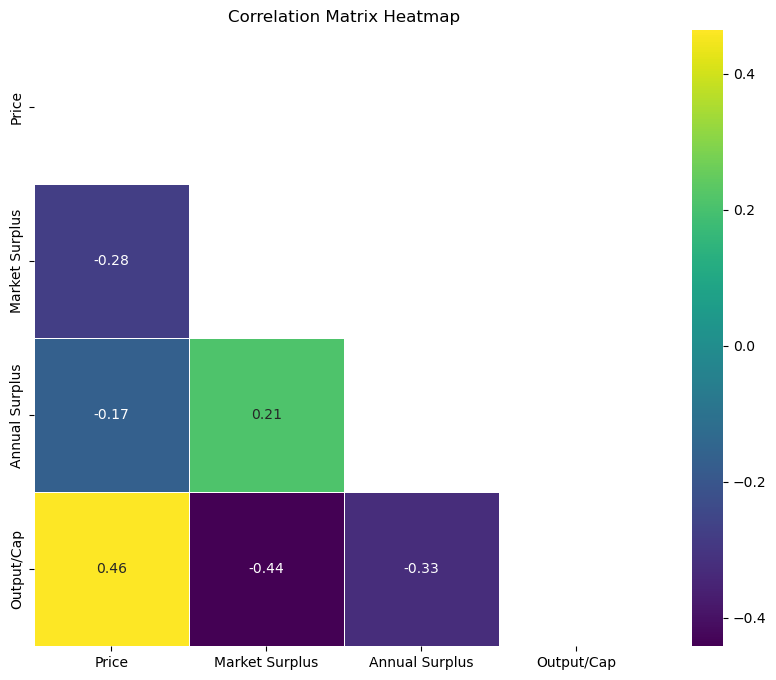

In [117]:
# Calculate the correlation matrix
correlation_matrix = df_standardized.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.7, mask=mask)

# Show the plot
plt.title('Correlation Matrix Heatmap')
plt.show()

very cool. Let's recap...

So far we have engineered three new features: 
1. Market Surplus which has a negative relationship with price. In fact, what we are measuring here is how Market Deficit boosts price. But the figures themselves are expressing Surplus; hence, the nagative sign in front of the correlation coefficient. Standing at -0.28 we can consider this correlation to be meaningful.
2. Annual Surplus which (again) has a negative relationship with price. This feature exhibits a weaker correlation with price. Standing at -0.17 it is more strongly correlated with Market Surplus (-0.21) and an even stronger relationship with Output/Capacity ratio, standing at -0.33. This feature might be dropped later.
3. Last but not least, output/capacity ratio, is the feature that shows the strongest correlation with price movements; standing at 0.46 it may turn out to be the strongest forward indicator of price spikes.

This progress is tremendous. But we are not done yet. Let's add Ontario Demand as well, do a Pearson test, and then we can make a decision about the features that we would lke to keep.

<hr>

## Demand as a feature

In [121]:
df.columns

Index(['Market Demand', 'Ontario Demand', 'HOEP', 'Output', 'capability',
       'Market Surplus'],
      dtype='object')

In [120]:
new_features_df.columns

Index(['2020 Demand', '2021 Demand', 'Annual Surplus', 'Output/Cap'], dtype='object')

Cool. We will take '2021 Demand' and use standard scalar method; then see if the correlation coefficient is strong enough for us to consider Ontario Demand as a feature for our Machine Learning Models.

In [122]:
# Standardize the columns using StandardScaler
scaler = StandardScaler()

df_standardized['2021 Demand'] = new_features_df['2021 Demand'].values

df_standardized[['Price', '2021 Demand']] = scaler.fit_transform(df_standardized[['Price', '2021 Demand']])

# Calculate the correlation coefficient
correlation = df_standardized['Price'].corr(df_standardized['2021 Demand'])

# Print the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.36167587180213295


Very cool. Now Let's check its p-value.

In [123]:
# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(df_standardized['Price'], df_standardized['2021 Demand'])

# Print the correlation coefficient and p-value
print("Correlation coefficient of Pearson test:", correlation_coefficient)
print("P-value of Pearson test:", p_value)

Correlation coefficient of Pearson test: 0.361675871802133
P-value of Pearson test: 5.710500757332307e-269


Cool. p-value is very small indeed! <br>

Let's take another look at our correlation Matrix.

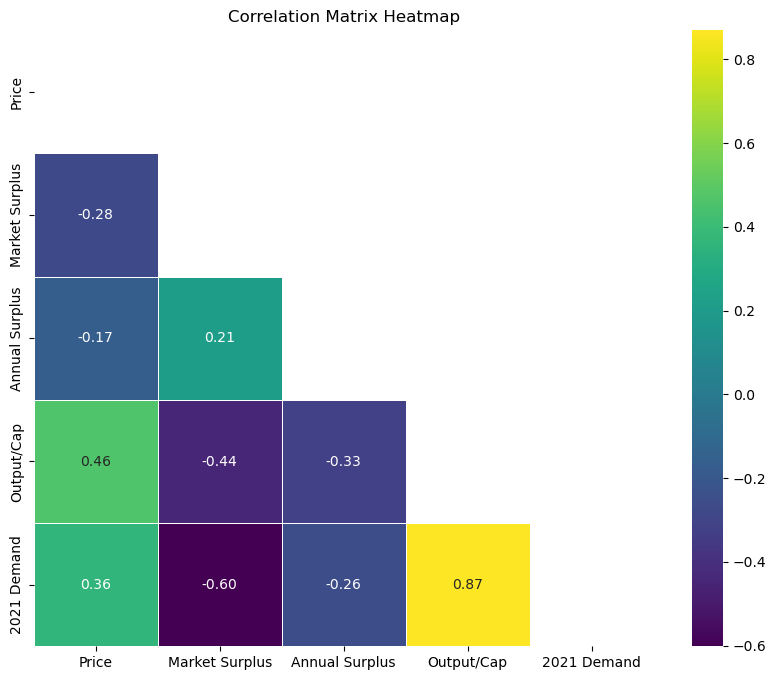

In [124]:
# Calculate the correlation matrix
correlation_matrix = df_standardized.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.7, mask=mask)

# Show the plot
plt.title('Correlation Matrix Heatmap')
plt.show()

Given the excessively strong correlation between '2021 Demand' and 'output/cap' I feel a strong reservation about keeping this feature.

Our final task before getting started with Machine Learning, would be Principal Component Analysis.

<hr>


# Principal Component Analysis

In [125]:
# PCA import statement
from sklearn.decomposition import PCA

In [126]:
new_features_df.columns

Index(['2020 Demand', '2021 Demand', 'Annual Surplus', 'Output/Cap'], dtype='object')

Let's copy the Market Surplus as well, before we do Principal Component Analysis.

In [127]:
df.columns

Index(['Market Demand', 'Ontario Demand', 'HOEP', 'Output', 'capability',
       'Market Surplus'],
      dtype='object')

In [128]:
new_features_df['Market Surplus'] = df['Market Surplus'].values

In [129]:
# sanity check
new_features_df.columns

Index(['2020 Demand', '2021 Demand', 'Annual Surplus', 'Output/Cap',
       'Market Surplus'],
      dtype='object')

In [130]:
new_features_df.describe()

,2020 Demand,2021 Demand,Annual Surplus,Output/Cap,Market Surplus
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,15050.499772,15279.019406,-228.519635,0.587794,916.996804
std,2498.570274,2303.635847,1742.380659,0.066384,867.515819
min,9831.000000,10426.000000,-8509.000000,0.436107,-1984.000000
25%,13175.000000,13592.750000,-1149.000000,0.537892,276.000000
50%,14714.500000,15116.000000,-318.500000,0.577814,855.000000
75%,16733.250000,16780.250000,577.250000,0.626921,1525.000000
max,24446.000000,22986.000000,9467.000000,0.815860,3576.000000


Let's drop the '2020 Demand' and get started with PCA.

In [131]:
new_features_df.drop(['2020 Demand'],axis=1,inplace=True)

In [132]:
# sanity check
new_features_df.columns

Index(['2021 Demand', 'Annual Surplus', 'Output/Cap', 'Market Surplus'], dtype='object')

In [133]:
my_PCA = PCA()

my_PCA.fit(new_features_df)

features_PCA = my_PCA.transform(new_features_df)

In [137]:
print(f"Variance captured by PC1: {my_PCA.explained_variance_[0]: 0.3f}")
print(f"Variance captured by PC2: {my_PCA.explained_variance_[1]: 0.3f}")
print(f"Variance captured by PC3: {my_PCA.explained_variance_[2]: 0.3f}")
print(f"Variance captured by PC4: {my_PCA.explained_variance_[3]: 0.3f}")

print(f"Proportion of variance captured by PC1: {my_PCA.explained_variance_ratio_[0]: 0.3f}")
print(f"Proportion of variance captured by PC2: {my_PCA.explained_variance_ratio_[1]: 0.3f}")
print(f"Proportion of variance captured by PC3: {my_PCA.explained_variance_ratio_[2]: 0.3f}")
print(f"Proportion of variance captured by PC4: {my_PCA.explained_variance_ratio_[3]: 0.3f}")

Variance captured by PC1:  6008465.470
Variance captured by PC2:  2633455.318
Variance captured by PC3:  453291.388
Variance captured by PC4:  0.001
Proportion of variance captured by PC1:  0.661
Proportion of variance captured by PC2:  0.290
Proportion of variance captured by PC3:  0.050
Proportion of variance captured by PC4:  0.000


In [138]:
my_PCA.explained_variance_ratio_

array([6.60618505e-01, 2.89543033e-01, 4.98384621e-02, 1.07491621e-10])

In [139]:
expl_var = my_PCA.explained_variance_ratio_

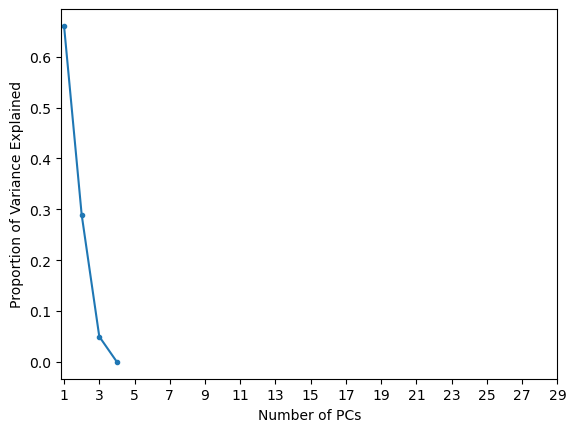

In [141]:
plt.figure()
plt.plot(range(1,5),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,31,2))
plt.show()

Cool. 

In [142]:
# Pull out the explained variance ratio
expl_var = my_PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

cumulative_sum

array([0.6606185 , 0.95016154, 1.        , 1.        ])

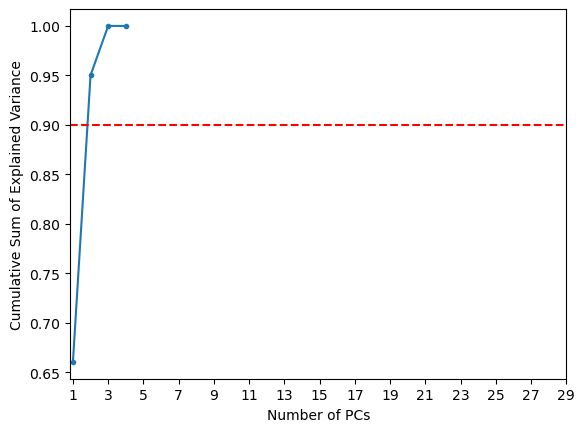

In [143]:
# Plot out the cumulative sum graph

plt.figure()
plt.plot(range(1,5), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,31,2))
plt.show()

Cool. Seems reasonable to keep three features, and thus reduce dimensionality as well as computetional burden on our processor, when we engage with Machine Learning models, later on.

<hr>

Right!

This concludes our work for this notebook, as we have achieved our objectives. We have three new features, with which we can explain more than 90% of the observed variations. We can now move on to the next steps: Data Modelling and Machine Learning.

In [144]:
new_features_df.to_csv('New Features IESO ML 2024.csv')

Next notebooks will be dedicated to Machine Learning algorithms.